# Task

### Pre-defined code

In [1]:
# # Mounting google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

In [2]:
# Loading all the images in the drive
gt_images = []

for files in tqdm(natsorted(glob('/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/cv-learnings/B/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images) # Only possible because all images are of same size

100%|██████████| 6/6 [00:00<00:00, 629.44it/s]


In [3]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

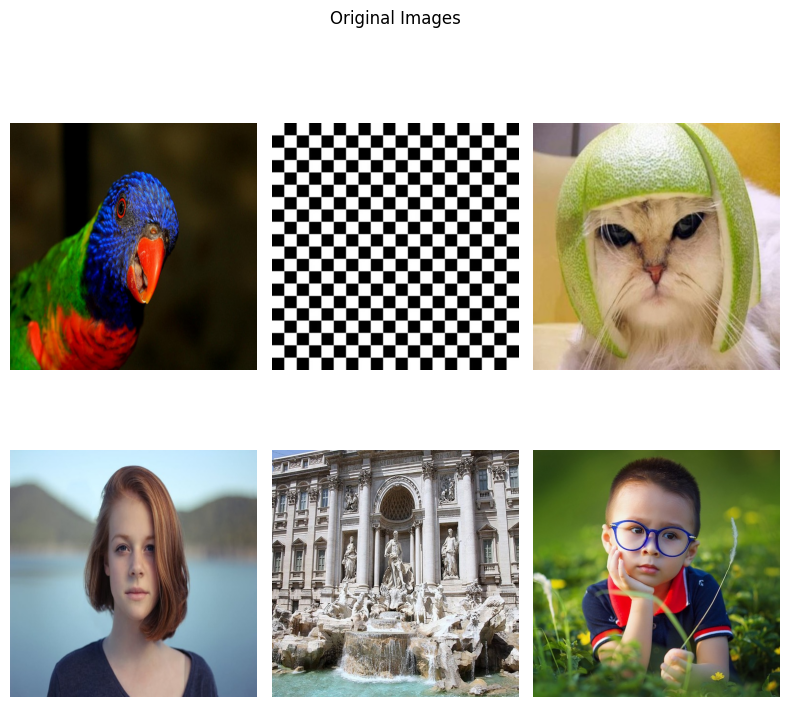

In [4]:
show_image_grid(gt_images, 2, 3, 'Original Images', figsize=8)

### Q1 [2 Marks]

Implement Gaussian Pyramid Downsampling method from scratch.Compare it with Opencv resize method. What difference do you observe when you resize an image with Gaussian Pyramid approach and Opencv approach.

References:
1. [Gaussian & Laplacian pyramid	construction](https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf)
2. [Multi-Scale Representation](https://medium.com/jun94-devpblog/cv-4-multi-scale-representation-gaussian-and-laplacian-pyramid-527ca4c4831c)

In [5]:
def pad_image_to_divisible(image, K, pad_value=0):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the padding needed for height and width
    pad_h = (K - (h % K)) % K  # Padding needed for height
    pad_w = (K - (w % K)) % K  # Padding needed for width

    # Compute the padding to add to top/bottom and left/right
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Pad the image: (top, bottom), (left, right), and (no padding on channels)
    if len(image.shape) == 3:  # For RGB images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                              mode='constant', constant_values=pad_value)
    else:  # For grayscale images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant', constant_values=pad_value)

    return padded_image

In [8]:
# Function to create a Gaussian kernel
def gaussian_kernel(size=5, sigma=1):
    """
    Creates a 2D Gaussian kernel.
    size: Kernel size (must be odd)
    sigma: Standard deviation for Gaussian
    """
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

# Function to convolve an image with a kernel
def convolve(image, kernel):
    """
    Convolves a given image with a specified kernel (2D convolution).
    image: Input image
    kernel: Gaussian kernel
    """
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')
    
    # Output image placeholder
    output = np.zeros_like(image)
    
    # Iterate over the image
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):  # For each channel
                # Extract the region of interest and perform element-wise multiplication
                region = padded_image[y:y + kernel_size, x:x + kernel_size, c]
                output[y, x, c] = np.sum(region * kernel)
    
    return output


# Function to downsample the image
def downsample(image):
    """
    Downsamples the image by taking every second pixel (factor of 2).
    """
    return image[::2, ::2]


# def gaussian_pyramid(image, levels):
#     pyramid = [image]
#     for i in range(levels - 1):
#         # Apply Gaussian blur and downsample by a factor of 2

#         # Write code here

        

#         image = pad_image_to_divisible(image, pyramid[0].shape[0])
#         pyramid.append(image)

#     return np.array(pyramid)


def gaussian_pyramid(image, levels):
    pyramid = [image]  # First level is the original image
    
    kernel = gaussian_kernel(5, sigma=1)  # Create a 5x5 Gaussian kernel
    
    for i in range(levels - 1):
        # Apply Gaussian blur (convolution) and downsample
        blurred = convolve(image, kernel)
        downsampled = downsample(blurred)
        downsampled = pad_image_to_divisible(downsampled, 2)  # Pad to keep dimensions divisible by 2 if needed
        pyramid.append(downsampled)  # Add the downsampled image to the pyramid
        image = downsampled  # Update the image for the next level
    
    return pyramid  # Return the list of images instead of converting to a NumPy array

def opencv_resize(inp_image, levels):
    pyramid = []
    h, w    = inp_image.shape[:2]
    for i in range(levels):
        # Apply Gaussian blur and downsample by a factor of 2
        # Write code here
        image = cv2.resize(inp_image, (h//2**i, w//2**i))

        image = pad_image_to_divisible(image, min(h, w))
        pyramid.append(image)

    return np.array(pyramid)

In [10]:
# Example usage:
for idx, image in enumerate(gt_images):
    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)

    # Access and process pyramid levels (as a list)
    for i, img in enumerate(s_image_pyramids):
        print(f"Level {i} shape: {img.shape}")

Level 0 shape: (512, 512, 3)
Level 1 shape: (256, 256, 3)
Level 2 shape: (128, 128, 3)
Level 3 shape: (64, 64, 3)
Level 0 shape: (512, 512, 3)
Level 1 shape: (256, 256, 3)
Level 2 shape: (128, 128, 3)
Level 3 shape: (64, 64, 3)
Level 0 shape: (512, 512, 3)
Level 1 shape: (256, 256, 3)
Level 2 shape: (128, 128, 3)
Level 3 shape: (64, 64, 3)
Level 0 shape: (512, 512, 3)
Level 1 shape: (256, 256, 3)
Level 2 shape: (128, 128, 3)
Level 3 shape: (64, 64, 3)
Level 0 shape: (512, 512, 3)
Level 1 shape: (256, 256, 3)
Level 2 shape: (128, 128, 3)
Level 3 shape: (64, 64, 3)
Level 0 shape: (512, 512, 3)
Level 1 shape: (256, 256, 3)
Level 2 shape: (128, 128, 3)
Level 3 shape: (64, 64, 3)


In [9]:
for idx, image in enumerate(gt_images):

    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)

    diff = []
    for gauss_img, open_img in zip(s_image_pyramids, s_image_opecv_resize):
        diff.append(cv2.subtract(gauss_img, open_img))
    diff = np.array(diff)

    show_image_grid(s_image_pyramids, 1, 4, 'Gaussian Pyramid', figsize=16)
    show_image_grid(s_image_opecv_resize, 1, 4, 'Opencv Resize', figsize=16)
    show_image_grid(diff, 1, 4, 'Difference', figsize=16)

error: OpenCV(4.10.0) /io/opencv/modules/core/src/arithm.cpp:658: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


### Q2 [4 Marks]

You have to implement image blending technique using Laplacian Pyramids from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Image Blending Using Laplacian Pyramids](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f)

In [ ]:
def laplacian_pyramid_blend_images(image_a, image_b):
    blended_image = None

    # Write your code here

    if blended_image == None:
        return image_a
    return blended_image

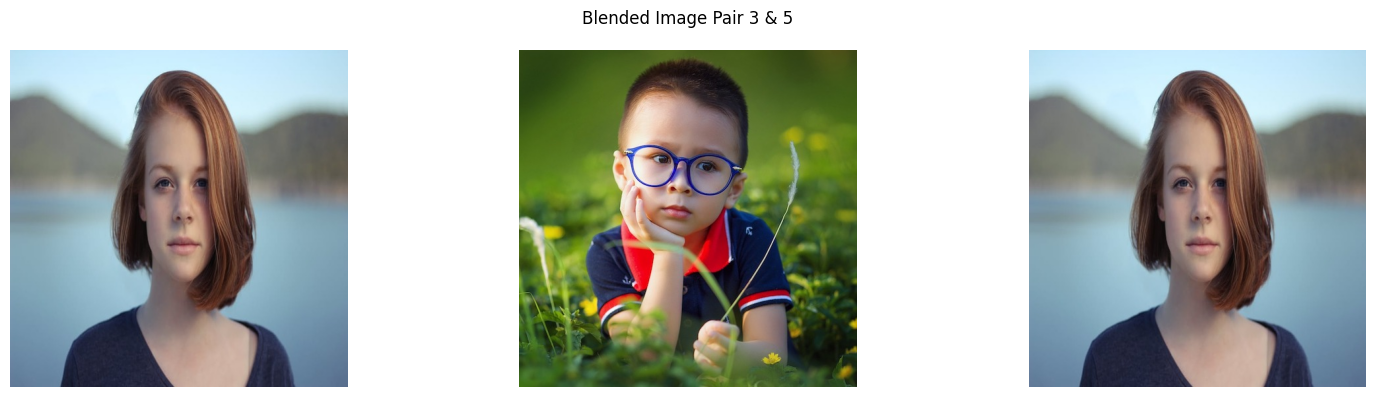

In [ ]:
blended_image = laplacian_pyramid_blend_images(gt_images[3], gt_images[5])
collage = np.array([gt_images[3], gt_images[5], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image Pair 3 & 5', figsize=16)

### Q3 [4 Marks]

Implement Harris and Hessian Corner Detector algorithm from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Harris and Hessian Corner Detector](https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd)

In [ ]:
def detect_harris_corner(image):
    corner_image  = None
    # Write your code here

    if corner_image == None:
        return image

    return corner_image

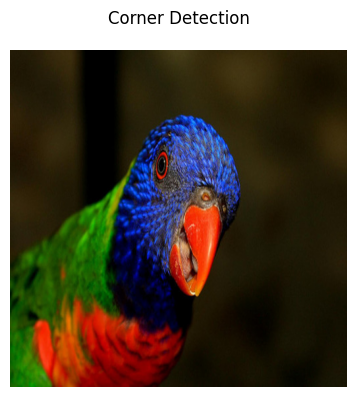

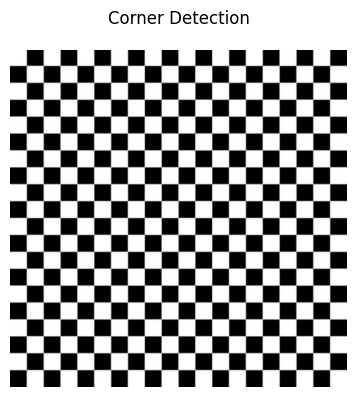

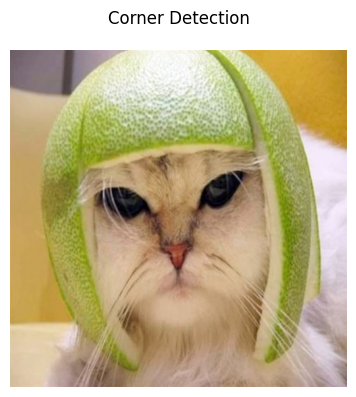

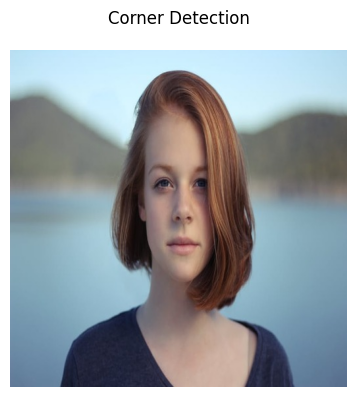

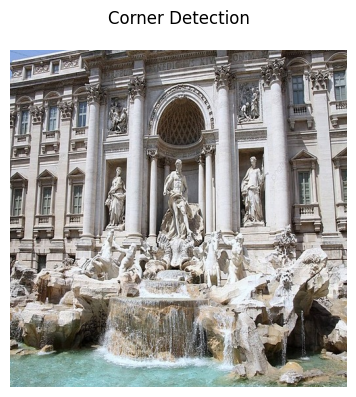

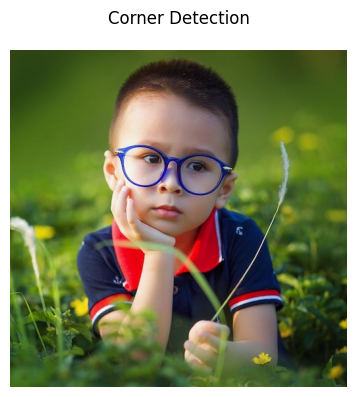

In [ ]:
for image in gt_images:
    corner_image = detect_harris_corner(image)
    show_image_grid(corner_image, 1, 1, 'Corner Detection', figsize=16)